Weather affects every single human on earth for the better or worse, and we've come to rely on weather predictions in order to plan how we spend our day. But how can we predict the weather? In this post we're going to develop a machine learning model with recurrent neural networks to see how well we can predict the weather.

As per previous posts we're going to go through the following steps (typical of any machine learning project):
1. Data exploration & analysis
2. Build a model
3. Train the model
4. Evaluate the model


In [103]:
import pandas as pd
import torch
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from tabulate import tabulate

# Data Exploration & Analysis

We'll be using rainfall records for Newcastle NSW retrieved from the Australian Bureau of Meteorology, this can be downloaded at: http://www.bom.gov.au/jsp/ncc/cdio/weatherData/av?p_nccObsCode=136&p_display_type=dailyDataFile&p_startYear=&p_c=&p_stn_num=061055

In [104]:
rainfall = pd.read_csv('data/IDCJAC0009_061055_1800_Data.csv')
print(tabulate(rainfall.head(1),headers=rainfall.columns))

    Product code      Bureau of Meteorology station number    Year    Month    Day    Rainfall amount (millimetres)    Period over which rainfall was measured (days)  Quality
--  --------------  --------------------------------------  ------  -------  -----  -------------------------------  ------------------------------------------------  ---------
 0  IDCJAC0009                                       61055    1862        1      1                                0                                               nan  Y


Let's clean it up

In [105]:
rainfall['timestamp'] = pd.to_datetime(rainfall[['Year', 'Month', 'Day']])
rainfall = rainfall.drop(['Product code','Bureau of Meteorology station number','Year','Month','Day','Period over which rainfall was measured (days)'],axis=1)
rainfall = rainfall.rename(columns={"Rainfall amount (millimetres)": "value","Quality": "quality"})
rainfall.head()

,value,quality,timestamp
0,0.0,Y,1862-01-01
1,0.0,Y,1862-01-02
2,0.0,Y,1862-01-03
3,0.0,Y,1862-01-04
4,0.0,Y,1862-01-05


Now that we've reduced the dataset into it's simplest form, timestamped data points, now we can start going into some feature engineering. Firstly we'll check some generic metrics of the dataset we're working with

In [109]:
print(f"First date: {rainfall.timestamp.min()}, last date: {rainfall.timestamp.max()}")
print(f"Number of points: {len(rainfall)}")
print(f"Number of missing points: {rainfall['value'].isna().sum()}")
print(f"Number of poor quality points: {len(rainfall[rainfall['quality'] == 'N'])}")

First date: 1862-01-01 00:00:00, last date: 2022-04-07 00:00:00
Number of points: 58536
Number of missing points: 1239
Number of poor quality points: 7249


With missing points making up around 2% of the dataset, there is a few ways we could treat this problem so our model doesn't predict invalid outputs. We could either impute these missing points, or discard them. Example ways of imputing the points could be as simple as taking the last (or next) valid recorded value for the missing point (this is known as back or forward filling), to as complex as modelling the data in different ways (ie, regression) to impute the values. For the simplicity of this experiment, we'll discard the missing timestamps as the timestamps are daily, if the time frame between points was shorter, imputing the values could be justified. 

In [111]:
rainfall = rainfall.dropna(subset=["value"])
rainfall = rainfall[rainfall['quality'] != 'N']
rainfall = rainfall.set_index('timestamp')

## Feature Engineering

Feature engineering is arguably the most important part of machine learning, as systems are only as good as what they are given, the old adage of 'shit in, shit out' holds true in this industry. Since we are trying to predict what the next value is with our rainfall model, we'll want to give the model what the previous rainfall values were. We do this by creating new columns called 'time lags' where it takes the value from n points in past and this becomes a feature. For example, if we were to look at the `lag7` column, that would contain the recorded rainfall a week prior to the selected data point.

For the first records in the dataset, since there is no value before it, this is a missing data point, and we have to discard these records as well, meaning that the choice on how many time lags to generate should consider the value of the first records in the dataset.

In [113]:
def generate_time_lags(df, value, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        lagged_values = list(df_n[value].shift(n))
        # We use concat here for performance reasons
        df_n = pd.concat([df_n, pd.Series(lagged_values, name=f"lag{n}",index=df_n.index)],axis=1)
    # Remove the first n rows where no 'previous' value is attainable for the number of lags
    df_n = df_n.iloc[n_lags:]
    return df_n

df_gen = generate_time_lags(rainfall, 'value', 100)

df_gen.head(2)

,value,quality,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,...,lag91,lag92,lag93,lag94,lag95,lag96,lag97,lag98,lag99,lag100
timestamp,,,,,,,,,,,,,,,,,,,,,
1862-04-11,1.0,Y,0.8,10.4,1.0,0.8,0.0,7.6,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1862-04-12,0.0,Y,1.0,0.8,10.4,1.0,0.8,0.0,7.6,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's generate features to be from the characteristics of the timestamp of when it was recorded:

In [119]:
df_features = (
                df_gen
                .assign(day = df_gen.index.day)
                .assign(month = df_gen.index.month)
                .assign(day_of_week = df_gen.index.dayofweek)
                .assign(week_of_year = df_gen.index.isocalendar().week)
              )

df_features.head(1).iloc[:,-4:]

,day,month,day_of_week,week_of_year
timestamp,,,,
1862-04-11,11,4,4,15


While us humans recognise that there's only so many days of the week, or weeks in the year, our model isn't going to realise this unless we tell it. To maintain the cyclical nature of these properties, we'll need to encode or transform them in a cyclical nature. To preserve this cyclical nature, using our trusty friends, sine and cosine. This is done a few steps:

1. Account for any starting value (ie, our months don't start on the 0th day)
2. Divide by the total period (ie, up to 31 days in a month)
3. Use these values as the circumference of a circle (cyclical)
4. Take the sine and cosine components from this circle

Ensuring that our data is consistent with how we understand dates, means we don't need to account for the different months having different number of days as the model being presented with both the month and day allowing to infer these together. One thought may be to combine these two dates to test whether it improves the performance of the model.

In [120]:
def cyclical_transformer(df, column, period, start_val, drop_original=True):
    df[f"{column}_sin"] = np.sin(2 * np.pi * (df[column] - start_val) / period)
    df[f"{column}_cos"] = np.cos(2 * np.pi * (df[column] - start_val) / period)
    if drop_original:
        df = df.drop(column, axis=1)
    return df

# The period and start values were determined from the min/max of the columns
cyclical_features = {"day": (31,1), "month": (12,1), "day_of_week": (6,0), "week_of_year": (53,1)}
for cyclical_feature, (period, start_val) in cyclical_features.items():
    df_features = cyclical_transformer(df_features, cyclical_feature, period, start_val)

Finally we've generated features for our model to use in it's predictions!

In [125]:
print(f"Number of features for the model: {(df_features.columns != 'value').sum()}")

Number of features for the model: 109


## Modelling

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

TEST_RATIO = 0.25

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_validation_test_split(df, target_col,test_ratio):
    validation_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_ratio, shuffle=False)
    return X_train, X_validation, X_test, y_train, y_validation, y_test

X_train, X_validation, X_test, y_train, y_validation, y_test = train_validation_test_split(df_features, 'rainfall', TEST_RATIO)

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_validation_scaled = scaler.transform(X_validation)
X_test_scaled = scaler.transform(X_test)

y_train_scaled = scaler.fit_transform(y_train)
y_validation_scaled = scaler.transform(y_validation)
y_test_scaled = scaler.transform(y_test)




In [13]:
BATCH_SIZE = 64

train = torch.utils.data.TensorDataset(torch.Tensor(X_train_scaled),torch.Tensor(y_train_scaled))
validation = torch.utils.data.TensorDataset(torch.Tensor(X_validation_scaled),torch.Tensor(y_validation_scaled))
test = torch.utils.data.TensorDataset(torch.Tensor(X_test_scaled),torch.Tensor(y_test_scaled))

train_loader = torch.utils.data.DataLoader(train,batch_size=BATCH_SIZE,shuffle=False, drop_last=True)
validation_loader = torch.utils.data.DataLoader(validation,batch_size=BATCH_SIZE,shuffle=False, drop_last=True)
test_loader = torch.utils.data.DataLoader(test,batch_size=BATCH_SIZE,shuffle=False, drop_last=True)


In [14]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension, layer_dimension, output_dimension, dropout_probability):
        super(RNNModel, self).__init__()

        self.hidden_dimension = hidden_dimension
        self.layer_dimension = layer_dimension

        self.rnn = torch.nn.RNN(
            input_size=input_dimension, hidden_size=hidden_dimension, num_layers=layer_dimension, batch_first=True, dropout=dropout_probability
        )
        self.fc = torch.nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        # Hidden state
        h0 = torch.zeros(self.layer_dimension, x.size(0), self.hidden_dimension).requires_grad_()

        out, h0 = self.rnn(x, h0.detach())

        out = out[:, -1, :]

        out = self.fc(out)
        return out

In [15]:
class LSTMModel(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension, layer_dimension, output_dimension, dropout_probability):
        super(LSTMModel, self).__init__()

        self.hidden_dimension = hidden_dimension
        self.layer_dimension = layer_dimension

        self.lstm = torch.nn.LSTM(
            input_dimension, hidden_dimension, layer_dimension, batch_first=True, dropout=dropout_probability
        )
        self.fc = torch.nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        # Hidden state
        h0 = torch.zeros(self.layer_dimension, x.size(0), self.hidden_dimension).requires_grad_()

        # LSTM Cell state
        c0 = torch.zeros(self.layer_dimension, x.size(0), self.hidden_dimension).requires_grad_()

        out= self.lstm(x, (h0.detach(), c0.detach()))

        out = out[:, -1, :]

        out = self.fc(out)
        return out

In [16]:
class GRUModel(torch.nn.Module):
    def __init__(self, input_dimension, hidden_dimension, layer_dimension, output_dimension, dropout_probability):
        super(GRUModel, self).__init__()

        self.hidden_dimension = hidden_dimension
        self.layer_dimension = layer_dimension

        self.gru = torch.nn.GRU(
            input_dimension, hidden_dimension, layer_dimension, batch_first=True, dropout=dropout_probability
        )
        self.fc = torch.nn.Linear(hidden_dimension, output_dimension)

    def forward(self, x):
        # Hidden state
        h0 = torch.zeros(self.layer_dimension, x.size(0), self.hidden_dimension).requires_grad_()

        out, h0 = self.gru(x, h0.detach())

        out = out[:, -1, :]

        out = self.fc(out)
        return out

In [17]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        model_path = f'models/{self.model}_{datetime.now().strftime("%Y-%m-%d %H:%M:%S").replace(" ", "_")}'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features])
                y_batch = y_batch
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features])
                    y_val = y_val
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        torch.save(self.model.state_dict(), model_path)

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features])
                y_test = y_test
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.detach().numpy())
                values.append(y_test.detach().numpy())

        return predictions, values

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses")
        plt.show()
        plt.close()

[1/100] Training loss: 0.0013	 Validation loss: 0.0011
[2/100] Training loss: 0.0012	 Validation loss: 0.0011
[3/100] Training loss: 0.0012	 Validation loss: 0.0010
[4/100] Training loss: 0.0012	 Validation loss: 0.0010
[5/100] Training loss: 0.0012	 Validation loss: 0.0010
[6/100] Training loss: 0.0012	 Validation loss: 0.0010
[7/100] Training loss: 0.0012	 Validation loss: 0.0010
[8/100] Training loss: 0.0012	 Validation loss: 0.0010
[9/100] Training loss: 0.0012	 Validation loss: 0.0010
[10/100] Training loss: 0.0012	 Validation loss: 0.0010
[50/100] Training loss: 0.0011	 Validation loss: 0.0010
[100/100] Training loss: 0.0011	 Validation loss: 0.0010


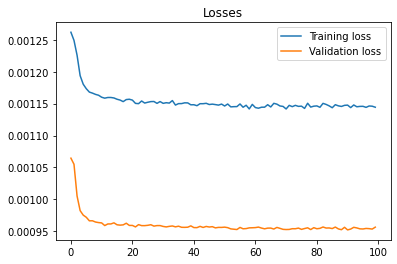

In [18]:
import torch.optim as optim

input_dimension = len(X_train.columns)
output_dimension = 1
hidden_dimension = 64
layer_dimension = 3
dropout = 0.2
n_epochs = 100
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dimension': input_dimension,
                'hidden_dimension' : hidden_dimension,
                'layer_dimension' : layer_dimension,
                'output_dimension' : output_dimension,
                'dropout_probability' : dropout}

model = LSTMModel(**model_params)

loss_fn = torch.nn.MSELoss(reduction="mean")
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
opt.train(train_loader, validation_loader, n_epochs=n_epochs, n_features=input_dimension)
opt.plot_losses()

In [19]:
predictions, values = opt.evaluate(test_loader, batch_size=64, n_features=input_dimension)

In [20]:
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df


def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["value", "prediction"]])
    return df_result


df_result = format_predictions(predictions, values, X_test, scaler)

df_result.head(5)

,value,prediction
timestamp,,
1982-02-22,0.000000,1.023296
1982-02-23,0.000000,1.097396
1982-02-24,23.599998,0.897786
1982-02-25,16.799999,9.289197
1982-02-26,9.800000,7.780343


In [21]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def calculate_metrics(df, source_col):
    return {'mae' : mean_absolute_error(df[source_col], df.prediction),
            'rmse' : mean_squared_error(df[source_col], df.prediction) ** 0.5,
            'r2' : r2_score(df[source_col], df.prediction)}

result_metrics = calculate_metrics(df_result,'value')

result_metrics

{'mae': 3.6310372, 'rmse': 8.79460372196865, 'r2': 0.0744602006661147}

In [22]:
from sklearn.linear_model import LinearRegression

def build_baseline_model(df, test_ratio, target_col):
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_ratio, shuffle=False
    )
    model = LinearRegression()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)

    result = pd.DataFrame(y_test)
    result["prediction"] = prediction
    result = result.sort_index()

    return result

df_baseline = build_baseline_model(df_features, TEST_RATIO, 'rainfall')
baseline_metrics = calculate_metrics(df_baseline,'rainfall')

<AxesSubplot:xlabel='timestamp'>

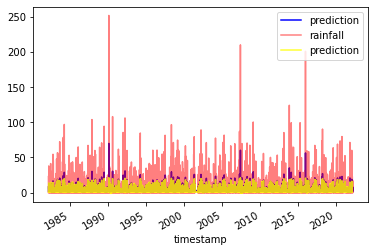

In [24]:
ax = df_baseline.prediction.plot(color='blue',legend=True)

df_baseline.rainfall.plot(color='red', ax=ax, legend=True,alpha=0.5)

df_result.prediction.plot(color='yellow',ax=ax,legend=True, alpha=0.8)

In [26]:
f'models/_{datetime.now().strftime("%Y-%m-%d %H:%M:%S")}'

'models/_2022-05-27 15:54:34'